In [1]:
import pandas as pd
import os
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import rasterio
from statsmodels.tsa.seasonal import STL
import numpy as np
from sklearn.linear_model import LinearRegression
import datetime as dt
from matplotlib.colors import TwoSlopeNorm 
import time
import sys
import plotly.express as px

oldpwd = os.getcwd()

sys.path.append(os.path.abspath("../../Functions"))
import dppd 

/home/luckyw0w/.local/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
import importlib
importlib.reload(dppd)

<module 'dppd' from '/home/luckyw0w/dicra/analytics/sandbox/notebooks/crop_fires/Functions/dppd.py'>

In [20]:
#fire_data_classified = pd.read_csv('fires_data_classified.geojson', index_col=0)
fire_data_classified = gpd.read_file('../../Classification_Fires/fires_data_classified.geojson')
#Select only the agricultural fires
fire_data = fire_data_classified[fire_data_classified['agricultural strict'] == 1]


telangana_shape = gpd.read_file('../../../../../../src/data_preprocessing/base_geojson/TL_state_shapefile_for_clip.geojson')

district_boundaries = gpd.read_file('../../../../../../src/data_preprocessing/base_geojson/TS_district_boundary.json')
district_boundaries = district_boundaries.reset_index()

mandal_boundaries = gpd.read_file('../../../../../../src/data_preprocessing/base_geojson/TS_mandal_boundary.json')
mandal_boundaries = mandal_boundaries.reset_index()


#Create geodataframe from the data
geo_fire_data = gpd.GeoDataFrame(fire_data,geometry = gpd.points_from_xy(fire_data.longitude,fire_data.latitude), crs = {'init': 'epsg:4326'}) 

#Make sure the geometry columns are in the right format
geo_fire_data['geometry'] = geo_fire_data['geometry'].geometry.to_crs(epsg = 4326)
district_boundaries['geometry'] = district_boundaries['geometry'].geometry.to_crs(epsg = 4326)
mandal_boundaries['geometry'] = mandal_boundaries['geometry'].geometry.to_crs(epsg = 4326)

#Load date into date format
geo_fire_data['acq_date'] =  pd.to_datetime(geo_fire_data['acq_date'])
geo_fire_data['year'] = (geo_fire_data['acq_date']).dt.year
geo_fire_data['month'] = (geo_fire_data['acq_date']).dt.month

#Select complete years (2015-2020)
geo_fire_data = geo_fire_data[(geo_fire_data['acq_date'] >= '2016-09-01') & (geo_fire_data['acq_date'] < '2019-09-1')]

In [21]:
print('Amount of fires detected: ' + str(len(geo_fire_data)))

Amount of fires detected: 2355


In [22]:
print('Amount of strict agricultural fires detected: '+ str(sum(geo_fire_data['agricultural strict'])))
print('Amount of agricultural fires detected: '+ str(sum(geo_fire_data['agricultural'])))

Amount of strict agricultural fires detected: 2355
Amount of agricultural fires detected: 2355


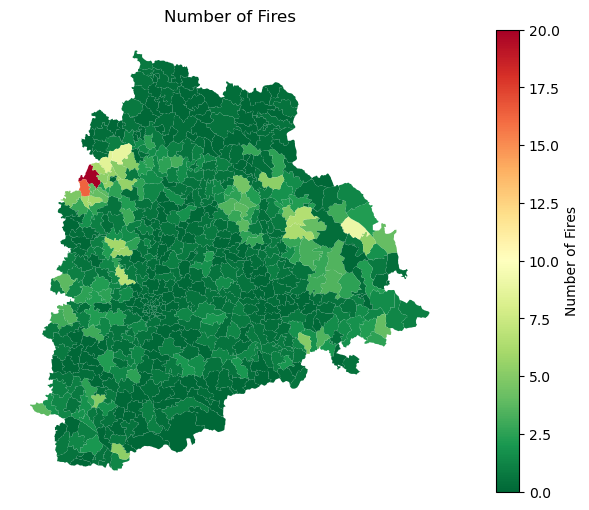

In [23]:
selected = geo_fire_data[geo_fire_data['agricultural']==1]
fires = gpd.sjoin(selected, mandal_boundaries, how="inner", op='intersects')

#Sort the values based on mandal and time
fires_count = fires.sort_values(by=['year'])
fires_count['Fire'] = 1

#Sum amount of frp (fire radiative power) per mandal per month per year make sure that if no fire happens at a specific time write a zero
fires_count = fires_count.groupby(['Dist_Name', 'Mandal_Nam', 'year'])['Fire'].sum().unstack(fill_value=0).stack().reset_index()
fires_count = fires_count.groupby(['Dist_Name', 'Mandal_Nam'])[0].mean().reset_index()

fires_count = fires_count.merge(mandal_boundaries[['Dist_Name', 'Mandal_Nam', 'geometry', 'index']], how='left', on=['Dist_Name', 'Mandal_Nam'])

indexes = fires_count['index'].to_list()

for i in range(0, len(mandal_boundaries)):
    if mandal_boundaries['index'].iloc[i] not in indexes:
        data = {'Dist_Name': mandal_boundaries['Dist_Name'].iloc[i], 'Mandal_Nam': mandal_boundaries['Mandal_Nam'].iloc[i], 0 : 0, 'geometry': mandal_boundaries['geometry'].iloc[i], 'index': mandal_boundaries['index'].iloc[i]}
        fires_count = fires_count.append(data, ignore_index=True)


fires_count = gpd.GeoDataFrame(fires_count,geometry = 'geometry', crs = {'init': 'epsg:4326'}) 

fires_count.plot(column = 0, legend = True, cmap = 'RdYlGn_r', figsize = (12, 6), legend_kwds = {'label': 'Number of Fires'}, )
plt.title('Number of Fires')
plt.axis('off')
plt.show()

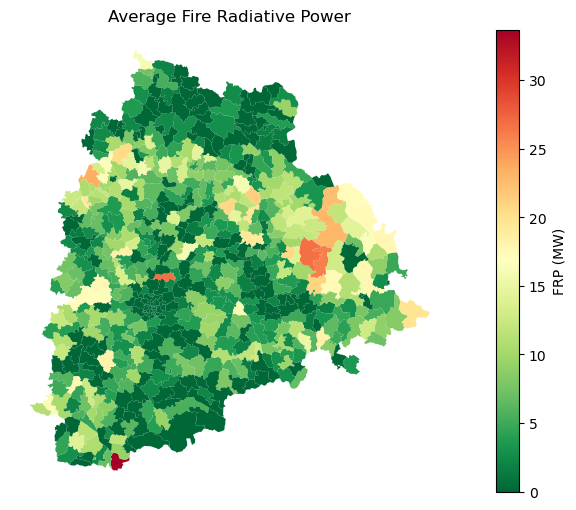

In [24]:
selected = geo_fire_data[geo_fire_data['agricultural']==1]
fires = gpd.sjoin(selected, mandal_boundaries, how="inner", op='intersects')

#Sort the values based on mandal and time
fires_count = fires.sort_values(by=['year'])

#Sum amount of frp (fire radiative power) per mandal per month per year make sure that if no fire happens at a specific time write a zero
fires_count = fires_count.groupby(['Dist_Name', 'Mandal_Nam', 'year'])['frp'].mean().unstack(fill_value=0).stack().reset_index()
fires_count = fires_count.groupby(['Dist_Name', 'Mandal_Nam'])[0].mean().reset_index()

fires_count = fires_count.merge(mandal_boundaries[['Dist_Name', 'Mandal_Nam', 'geometry', 'index']], how='left', on=['Dist_Name', 'Mandal_Nam'])

indexes = fires_count['index'].to_list()

for i in range(0, len(mandal_boundaries)):
    if mandal_boundaries['index'].iloc[i] not in indexes:
        data = {'Dist_Name': mandal_boundaries['Dist_Name'].iloc[i], 'Mandal_Nam': mandal_boundaries['Mandal_Nam'].iloc[i], 0 : 0, 'geometry': mandal_boundaries['geometry'].iloc[i], 'index': mandal_boundaries['index'].iloc[i]}
        fires_count = fires_count.append(data, ignore_index=True)

fires_count = gpd.GeoDataFrame(fires_count,geometry = 'geometry', crs = {'init': 'epsg:4326'}) 

fires_count.plot(column = 0, legend = True, cmap = 'RdYlGn_r', figsize = (12, 6), legend_kwds = {'label': 'FRP (MW)'}, )
plt.title('Average Fire Radiative Power')
plt.axis('off')
plt.show()

In [25]:
fires_count[0].mean()

5.331279440953728

In [26]:
fires_count.sort_values(by=0, ascending = False).head(10)
#fires_count[0].mean()

,Dist_Name,Mandal_Nam,0,geometry,index
63,Jogulamba Gadwal,Alampur,33.691667,"POLYGON ((78.25116 15.97345, 78.25126 15.97295...",10
135,Mahabubabad,Kothaguda,26.780556,"POLYGON ((80.08120 18.06924, 80.08199 18.06911...",257
328,Siddipet,Mulug,26.725000,"POLYGON ((78.68218 17.75236, 78.68220 17.75215...",340
131,Mahabubabad,Gangaram,25.937500,"POLYGON ((80.23231 18.02202, 80.24249 18.01442...",145
238,Nizamabad,Bodhan,23.516425,"POLYGON ((77.94774 18.70379, 77.94776 18.70360...",68
183,Mulugu,Tadvai (Sammakka Sarakka),23.000000,"POLYGON ((80.23307 18.39378, 80.23058 18.39212...",488
180,Mulugu,Kannaigudem,22.500000,"POLYGON ((80.38763 18.59736, 80.39056 18.59276...",216
272,Peddapalli,Srirampur,21.404167,"POLYGON ((79.52125 18.57593, 79.51716 18.57286...",482
129,Mahabubabad,Bayyaram,20.947917,"POLYGON ((80.24150 17.73461, 80.24211 17.73352...",46
98,Karimnagar,Manakondur,20.712500,"POLYGON ((79.35329 18.45174, 79.35136 18.44853...",300


In [27]:
#Select one year
fire_data_2019 = fire_data[fire_data['year']==2019]
fires_agr_2019 = fires[fires['year']==2019]

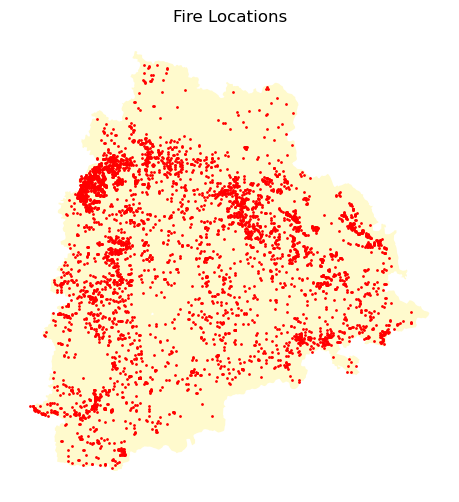

In [28]:
telangana_shape.plot(figsize = (12, 6), color='lemonchiffon')
plt.scatter(fire_data.longitude, fire_data.latitude, c='red', edgecolor = 'red', s=1)
plt.title('Fire Locations')
plt.axis('off')
plt.show()

In [29]:
selected = geo_fire_data[geo_fire_data['agricultural']==1]
fires = gpd.sjoin(selected, mandal_boundaries, how="inner", op='intersects')

selected_strict = geo_fire_data[geo_fire_data['agricultural strict']==1]
fires_strict = gpd.sjoin(selected_strict, mandal_boundaries, how="inner", op='intersects')

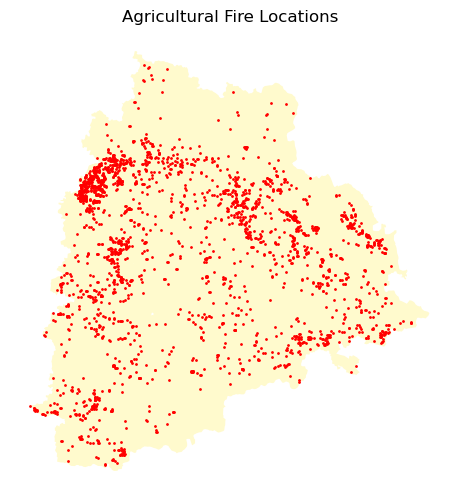

In [30]:
telangana_shape.plot(color = 'lemonchiffon', figsize = (12, 6))
plt.scatter(fires.longitude, fires.latitude, c='red', edgecolor = 'red', s=1)
plt.title('Agricultural Fire Locations')
plt.axis('off')
plt.show()

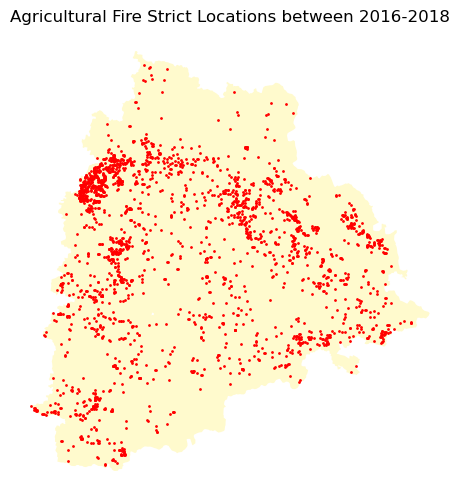

In [31]:
telangana_shape.plot(color = 'lemonchiffon', figsize = (12, 6))
plt.scatter(fires_strict.longitude, fires_strict.latitude, c='red', edgecolor = 'red', s=1)
plt.title('Agricultural Fire Strict Locations between 2016-2018')
plt.axis('off')
plt.show()

In [32]:

geo_fire_data = gpd.GeoDataFrame(fire_data,geometry = fire_data.geometry)#, crs = {'init': 'epsg:4326'}) 

#Make sure the geometry columns are in the right format
geo_fire_data = geo_fire_data[['geometry', 'acq_date', 'fireID', 'frp']]
geo_fire_data['geometry'] = geo_fire_data['geometry'].to_crs(epsg = 4326)
boundaries = gpd.GeoDataFrame(mandal_boundaries,geometry = mandal_boundaries.geometry)#, crs = {'init': 'epsg:4326'}) 

#Load date into date format
geo_fire_data['acq_date'] =  pd.to_datetime(geo_fire_data['acq_date'])
geo_fire_data['year'] = (geo_fire_data['acq_date']).dt.year
geo_fire_data['month'] = (geo_fire_data['acq_date']).dt.month
geo_fire_data['day'] = (geo_fire_data['acq_date']).dt.day

#Selects the years we are interested in, depending on the input of the function
geo_fire_data = geo_fire_data[(geo_fire_data['acq_date'] >= str(2016)+'-01-01') & (geo_fire_data['acq_date'] < str(2019+1)+'-01-01')]

#Count all fires within a region given by the boundaries dataframe
fires_per_boundaries= gpd.sjoin(geo_fire_data, boundaries, how="inner")

#Create the right time format: We count per month
fires_per_boundaries['day'] = 1 
fires_per_boundaries['year'] = pd.Series(pd.to_numeric(fires_per_boundaries['year'], errors='coerce'), dtype='int64')
fires_per_boundaries['month'] = pd.Series(pd.to_numeric(fires_per_boundaries['month'], errors='coerce'), dtype='int64')
fires_per_boundaries['ModifiedDateTime'] = pd.to_datetime(fires_per_boundaries[['year', 'month', 'day']].astype('int64').astype('str'), yearfirst=True)



unit = 'Number of Fires'
#Sum amount of fires per mandal per month per year make sure that if no fire happens at a specific time write a zero
fires_per_boundaries_count = fires_per_boundaries.groupby(['index', 'ModifiedDateTime'])['fireID'].count().unstack(fill_value=0).stack().reset_index()
fires_per_boundaries_count['Value'] = fires_per_boundaries_count[0] 

In [33]:
mandal_boundaries[mandal_boundaries['Mandal_Nam'] == 'Yellandu']

,index,Area,S_No,No_HH,TOT_P,TOT_M,TOT_F,P_06,M_06,F_06,...,F_SC,P_ST,M_ST,F_ST,Shape_Leng,Shape_Area,Mandal_Nam,Dist_Name,N_Revenue,geometry
553,553,446.0,41.0,24563.0,95394.0,46626.0,48768.0,9227.0,4683.0,4544.0,...,6329.0,35613.0,17025.0,18588.0,1.166998,44661.83757,Yellandu,Bhadradri Kothagudem,Kothagudem,"POLYGON ((80.34248 17.78495, 80.39431 17.74970..."


In [34]:
import importlib
importlib.reload(dppd)

<module 'dppd' from '/home/luckyw0w/dicra/analytics/sandbox/notebooks/crop_fires/Functions/dppd.py'>

In [35]:
dppd.Trend_Score(fires_per_boundaries_count, 553, 3)

-0.015559756324949643

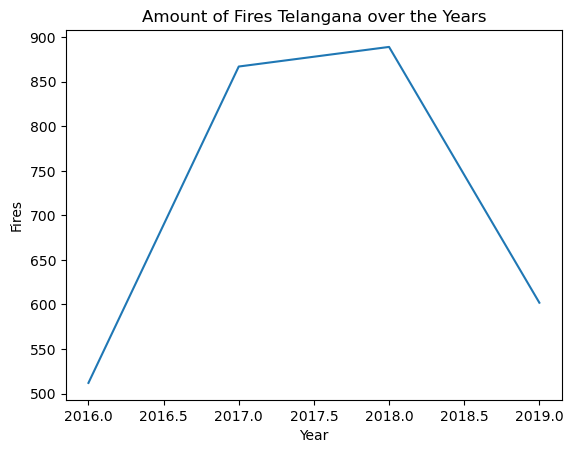

In [36]:
#Create a dataframe that shows the fire location (mandal basis)
fires = gpd.sjoin(geo_fire_data, telangana_shape, how="inner", op='intersects')

#Sort the values based on mandal and time
fires_count = fires.sort_values(by=['year'])

#Sum amount of frp (fire radiative power) per mandal per month per year make sure that if no fire happens at a specific time write a zero
fires_count = fires_count.groupby(['year'])['fireID'].count().reset_index()

plt.plot(fires_count['year'], fires_count['fireID'])
plt.title('Amount of Fires Telangana over the Years')
plt.xlabel('Year')
plt.ylabel('Fires')
plt.show()


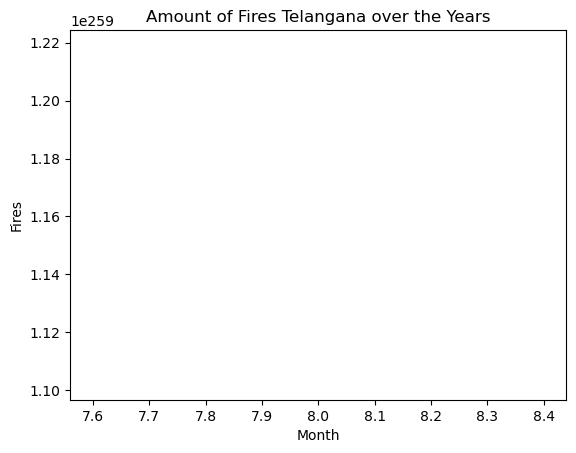

In [37]:
#Create a dataframe that shows the fire location (mandal basis)
fires = gpd.sjoin(geo_fire_data, telangana_shape, how="inner", op='intersects')

#Sort the values based on mandal and time
fires_count = fires.sort_values(by=['month'])

#Sum amount of frp (fire radiative power) per mandal per month per year make sure that if no fire happens at a specific time write a zero
fires_count = fires_count.groupby(['month'])['fireID'].mean().reset_index()

plt.plot(fires_count['month'], fires_count['fireID'])
plt.title('Amount of Fires Telangana over the Years')
plt.xlabel('Month')
plt.ylabel('Fires')
plt.show()

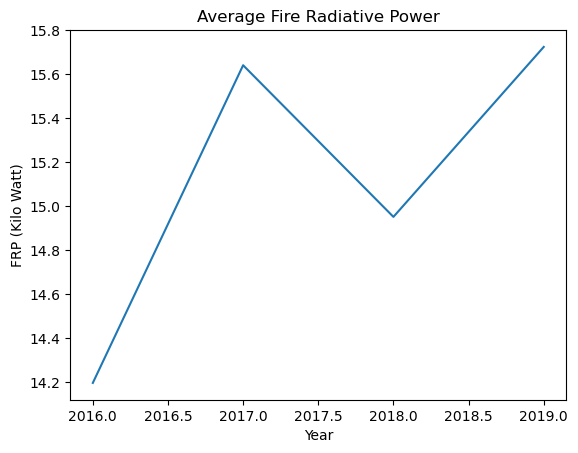

In [38]:
#Create a dataframe that shows the fire location (mandal basis)
fires = gpd.sjoin(geo_fire_data, telangana_shape, how="inner", op='intersects')

#Sort the values based on mandal and time
fires_count = fires.sort_values(by=['year'])

#Sum amount of frp (fire radiative power) per mandal per month per year make sure that if no fire happens at a specific time write a zero
fires_count = fires_count.groupby(['year'])['frp'].mean().reset_index()

plt.plot(fires_count['year'], fires_count['frp'])
plt.title('Average Fire Radiative Power')
plt.xlabel('Year')
plt.ylabel('FRP (Kilo Watt)')
plt.show()

In [39]:
fires_per_mandal = gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner", op='intersects')
fires_per_mandal_count = fires_per_mandal.groupby(['Mandal_Nam', 'year',])['fireID'].count().unstack(fill_value=0).stack().reset_index()
fires_per_mandal_count['Fires'] = fires_per_mandal_count[0]
fig = px.line(fires_per_mandal_count, x="year", y='Fires', color='Mandal_Nam', title='Amount of Fires per Mandal in Telangana over the Years')
fig.show()
fig = px.bar(fires_per_mandal_count, x="year", y='Fires', color='Mandal_Nam', title='Amount of Fires per Mandal in Telangana over the Years', barmode='group')
fig.show()
total_fires = fires_per_mandal_count.groupby('Mandal_Nam')['Fires'].sum().reset_index()
total_fires = total_fires.sort_values(by='Fires', ascending = False)
fig = px.bar(total_fires, x='Mandal_Nam', y='Fires', title = 'Total Amount of Fires per Mandal')
fig.show()


In [40]:
fires_per_mandal = gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner", op='intersects')
fires_per_mandal_count = fires_per_mandal.groupby(['Mandal_Nam', 'year',])['frp'].mean().unstack(fill_value=0).stack().reset_index()
fires_per_mandal_count['Frp (Kilo Watts)'] = fires_per_mandal_count[0]
fig = px.line(fires_per_mandal_count, x="year", y = 'Frp (Kilo Watts)', color='Mandal_Nam', title='Average Fire Radiative Power per Mandal over the Years')
fig.show()

fig = px.bar(fires_per_mandal_count, x="year", y = 'Frp (Kilo Watts)', color='Mandal_Nam', title='Average Fire Radiative Power per Mandal over the Years', barmode='group')
fig.show()